In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder_path = "/content/drive/MyDrive/AIH_1"
dataframe = []

# Running a Loop over all CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframe.append(df)

data = pd.concat(dataframe, ignore_index=True)
data.head()

,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,addiction,iephillips,2019/04/16,Heroin Should I tell my ex wife that I tried h...,-1.124545,0.735499,0.500455,101.270682,106.272727,2.200000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,addiction,michaelmichael861,2019/04/16,"Strange side effects, please give any advice. ...",5.584860,7.139272,5.709818,78.807113,68.003436,8.291998,...,0.0,0.155190,0.0,0.078136,0.0,0.0,0.038121,0.0,0.456453,0.069116
2,addiction,waismannmethod,2019/04/16,New York Heroin Use Figures Higher Than US Ave...,9.236875,10.646774,8.876786,59.918214,59.625000,11.400000,...,0.0,0.113536,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.075847
3,addiction,StunnyG,2019/04/16,New here but not to recovery. Looking to share...,4.708364,7.273881,4.898182,79.537273,72.454545,7.672727,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,addiction,8923578295789advice,2019/04/16,im clean my aunt (who i live with) found a pac...,3.315069,3.506576,3.940714,94.416786,72.271889,7.305991,...,0.0,0.000000,0.0,0.196025,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [6]:
full_data = data.copy()
full_data.shape

(548919, 350)

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548919 entries, 0 to 548918
Columns: 350 entries, subreddit to tfidf_year
dtypes: float64(270), int64(76), object(4)
memory usage: 1.4+ GB


## **Data Pre-Processing**

In [8]:
# Looking for special characters in the 'post' column

all_text = ' '.join(full_data['post'].astype(str))

special_chars = re.findall(r'[^a-zA-Z0-9\s]', all_text)
count_special_char = Counter(special_chars)
count_special_char

Counter({'?': 790340,
         ',': 2992767,
         '.': 5150365,
         "'": 1717763,
         '-': 495240,
         '&': 109827,
         ';': 225403,
         '#': 71968,
         '/': 415590,
         '!': 174603,
         '[': 53251,
         ']': 53295,
         '(': 465035,
         ':': 225472,
         ')': 478560,
         '"': 312730,
         '’': 1145892,
         '+': 20389,
         '‘': 10506,
         '—': 7880,
         '“': 82529,
         '”': 83198,
         'é': 3848,
         '%': 64111,
         '✌': 189,
         '🏻': 468,
         '=': 22588,
         '_': 47842,
         '🔥': 46,
         '💯': 39,
         '✅': 72,
         '🚨': 27,
         '$': 135817,
         '…': 2632,
         '*': 205369,
         '\\': 49585,
         '£': 3274,
         '❤': 1109,
         '️': 2643,
         '👊': 8,
         '×': 369,
         '💅': 12,
         '💔': 88,
         '@': 3768,
         '~': 14524,
         '😭': 921,
         '≠': 8,
         '👆': 6,
         '–': 33

In [9]:
stop_words = set(stopwords.words('english'))

# Cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text_tokens = text.split()
    text_tokens = [word for word in text_tokens if word not in stop_words]
    cleaned_text = ' '.join(text_tokens)
    return cleaned_text

full_data['post'] = full_data['post'].apply(lambda x: clean_text(str(x)))
full_data[['post']].head()

,post
0,heroin tell ex wife tried heroin
1,strange side effects please give advice roughl...
2,new york heroin use figures higher us average ...
3,new recovery looking share songvideo know exac...
4,im clean aunt live found packet cigarettes tra...


In [10]:
# Tokenizing the 'cleaned_post' column

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(full_data['post'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())

tfidf_df.head()

,00,000,0000,00000,000000,0000000,00000000,000000000,0000000000,00000000000000000021e800c1e8df51b22c1588e5a624bea17e9faa34b2dc4a,...,zzzquilmy,zzzquilpart,zzzs,zzzz,zzzzz,zzzzzthen,zzzzzzz,zzzzzzzzzzzz,zzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
tfidf_df.shape

(548919, 372792)

In [12]:
# tokenizing the "post" column
tokenized_posts = full_data['post'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences = tokenized_posts, vector_size = 100, window = 5, min_count = 1, workers = 4)

# Vectorising the "post" column using Word2Vec embedding
def get_post_vector(post):
    word_vectors = [w2v_model.wv[word] for word in post if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

full_data['post_vector'] = tokenized_posts.apply(get_post_vector)
full_data[['post', 'post_vector']].head()

,post,post_vector
0,heroin tell ex wife tried heroin,"[-0.74907994, 0.0096670985, -0.73337865, -0.81..."
1,strange side effects please give advice roughl...,"[-0.36200795, -0.25468186, 0.069044895, -0.699..."
2,new york heroin use figures higher us average ...,"[0.061049685, 0.10765283, -0.397906, -0.175145..."
3,new recovery looking share songvideo know exac...,"[-0.65077525, -0.1655888, 0.07821595, 0.299703..."
4,im clean aunt live found packet cigarettes tra...,"[-0.19473653, 0.20390639, 0.629233, -0.4127836..."


In [13]:
le = LabelEncoder()
full_data['subreddit_encoded'] = le.fit_transform(full_data['subreddit'])

In [14]:
X_TFIDF = tfidf_matrix
X_W2V = np.array(full_data['post_vector'].tolist())
Y = full_data['subreddit_encoded']

## **Model 1: Logistic Regression**

In [16]:
x1_TFIDF_train, x1_TFIDF_test, y1_TFIDF_train, y1_TFIDF_test = train_test_split(X_TFIDF, Y, test_size = 0.2, random_state = 42)
print(x1_TFIDF_train.shape)
print(x1_TFIDF_test.shape)
print(y1_TFIDF_train.shape)
print(y1_TFIDF_test.shape)

(439135, 372792)
(109784, 372792)
(439135,)
(109784,)


In [17]:
x1_W2V_train, x1_W2V_test, y1_W2V_train, y1_W2V_test = train_test_split(X_W2V, Y, test_size = 0.2, random_state = 42)

***Building the logistic regression model on TF-IDF matrix:***

In [30]:
# model1_TFIDF = LogisticRegression()
# model1_TFIDF.fit(x1_TFIDF_train, y1_TFIDF_train)
# y1_TFIDF_pred = model1_TFIDF.predict(x1_TFIDF_test)

In [ ]:
# cm1_TFIDF = confusion_matrix(y1_TFIDF_test, y1_TFIDF_pred)
# print(cm1_TFIDF)

In [ ]:
# plt.figure(figsize = (20, 6))
# sns.heatmap(cm1_TFIDF, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = le.classes_, yticklabels = le.classes_, linewidths = 0.3, linecolor ='black')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Multi-class Classification using Logistic Regression on TF-IDF')
# plt.show()

In [ ]:
# precision1_TFIDF = precision_score(y1_TFIDF_test, y1_TFIDF_pred, average = 'weighted')
# recall1_TFIDF = recall_score(y1_TFIDF_test, y1_TFIDF_pred, average = 'weighted')

# print("Accuracy1_TFIDF:", accuracy_score(y1_TFIDF_test, y1_TFIDF_pred))
# print(f"Weighted Precision1_TFIDF: {precision1_TFIDF:.4f}")
# print(f"Weighted Recall1_TFIDF: {recall1_TFIDF:.4f}")
# print("Classification Report 1_TFIDF:")
# print(classification_report(y1_TFIDF_test, y1_TFIDF_pred, target_names = le.classes_)

***Building the logistic regression model on Word2vec embeddings:***

In [18]:
model1_W2V = LogisticRegression()
model1_W2V.fit(x1_W2V_train, y1_W2V_train)
y1_W2V_pred = model1_W2V.predict(x1_W2V_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


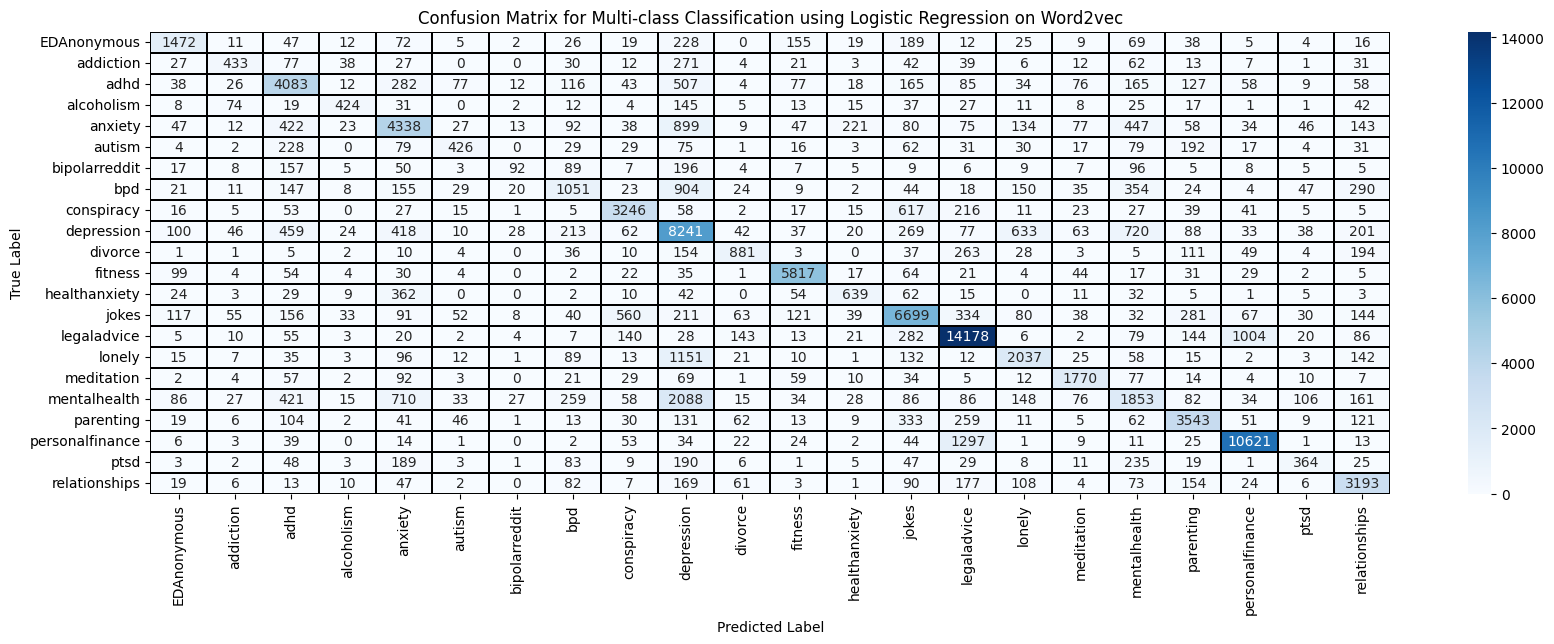

In [19]:
cm1_W2V = confusion_matrix(y1_W2V_test, y1_W2V_pred)
plt.figure(figsize = (20, 6))
sns.heatmap(cm1_W2V, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = le.classes_, yticklabels = le.classes_, linewidths = 0.3, linecolor ='black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification using Logistic Regression on Word2vec')
plt.show()

In [24]:
precision1_W2V = precision_score(y1_W2V_test, y1_W2V_pred, average = 'weighted')
recall1_W2V = recall_score(y1_W2V_test, y1_W2V_pred, average = 'weighted')

print("Accuracy1_W2V:", accuracy_score(y1_W2V_test, y1_W2V_pred))
print(f"Weighted Precision1_W2V: {precision1_W2V:.4f}")
print(f"Weighted Recall1_W2V: {recall1_W2V:.4f}")
print("Classification Report 1_W2V:")
print(classification_report(y1_W2V_test, y1_W2V_pred, target_names = le.classes_))

Accuracy1_W2V: 0.6868122859433069
Weighted Precision1_W2V: 0.6808
Weighted Recall1_W2V: 0.6868
Classification Report 1_W2V:
                 precision    recall  f1-score   support

    EDAnonymous       0.69      0.60      0.64      2435
      addiction       0.57      0.37      0.45      1156
           adhd       0.61      0.67      0.64      6072
     alcoholism       0.67      0.46      0.55       921
        anxiety       0.60      0.60      0.60      7282
         autism       0.56      0.31      0.40      1355
  bipolarreddit       0.43      0.12      0.18       790
            bpd       0.46      0.31      0.37      3370
     conspiracy       0.73      0.73      0.73      4444
     depression       0.52      0.70      0.60     11822
        divorce       0.64      0.49      0.56      1801
        fitness       0.89      0.92      0.90      6306
  healthanxiety       0.58      0.49      0.53      1308
          jokes       0.71      0.72      0.72      9251
    legaladvice     

## **Model 2: Decision Tree**

In [25]:
x2_TFIDF_train, x2_TFIDF_test, y2_TFIDF_train, y2_TFIDF_test = train_test_split(X_TFIDF, Y, test_size = 0.2, random_state = 42)
x2_W2V_train, x2_W2V_test, y2_W2V_train, y2_W2V_test = train_test_split(X_W2V, Y, test_size = 0.2, random_state = 42)

***Building the Decision Tree model on TF-IDF matrix:***

In [29]:
# model2_TFIDF = DecisionTreeClassifier(random_state = 42)
# model2_TFIDF.fit(x2_TFIDF_train, y2_TFIDF_train)
# y2_TFIDF_pred = model2_TFIDF.predict(x2_TFIDF_test)

In [28]:
# cm2_TFIDF = confusion_matrix(y2_TFIDF_test, y2_TFIDF_pred)

# plt.figure(figsize = (20, 6))
# sns.heatmap(cm2_TFIDF, annot = True, fmt = 'd', cmap = 'Oranges', xticklabels = le.classes_, yticklabels = le.classes_, linewidths = 0.3, linecolor ='black')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Multi-class Classification using Decision tree on TF-IDF')
# plt.show()

In [27]:
# precision2_TFIDF = precision_score(y2_TFIDF_test, y2_TFIDF_pred, average = 'weighted')
# recall2_TFIDF = recall_score(y2_TFIDF_test, y2_TFIDF_pred, average = 'weighted')

# print("Accuracy2_TFIDF:", accuracy_score(y2_TFIDF_test, y2_TFIDF_pred))
# print(f"Weighted Precision2_TFIDF: {precision2_TFIDF:.4f}")
# print(f"Weighted Recall2_TFIDF: {recall2_TFIDF:.4f}")
# print("Classification Report 2_TFIDF:")
# print(classification_report(y2_TFIDF_test, y2_TFIDF_pred, target_names = le.classes_))

***Building the Decission Tree model on Word2vec embedding:***

In [31]:
model2_W2V = DecisionTreeClassifier(random_state = 42)
model2_W2V.fit(x2_W2V_train, y2_W2V_train)
y2_W2V_pred = model2_W2V.predict(x2_W2V_test)

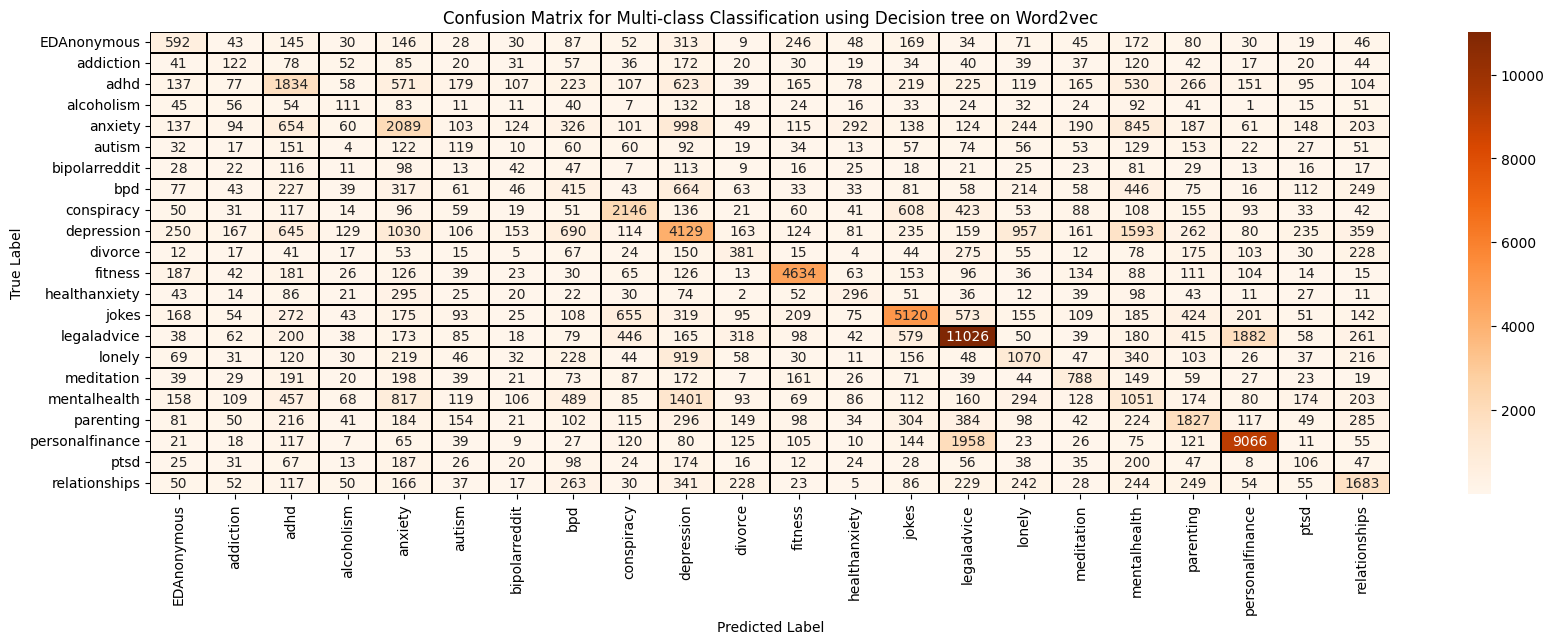

In [51]:
cm2_W2V = confusion_matrix(y2_W2V_test, y2_W2V_pred)

plt.figure(figsize = (20, 6))
sns.heatmap(cm2_W2V, annot = True, fmt = 'd', cmap = 'Oranges', xticklabels = le.classes_, yticklabels = le.classes_, linewidths = 0.3, linecolor ='black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification using Decision tree on Word2vec')
plt.show()

In [33]:
precision2_W2V = precision_score(y2_W2V_test, y2_W2V_pred, average = 'weighted')
recall2_W2V = recall_score(y2_W2V_test, y2_W2V_pred, average = 'weighted')

print("Accuracy2_W2V:", accuracy_score(y2_W2V_test, y2_W2V_pred))
print(f"Weighted Precision2_W2V: {precision2_W2V:.4f}")
print(f"Weighted Recall2_W2V: {recall2_W2V:.4f}")
print("Classification Report 2_W2V:")
print(classification_report(y2_W2V_test, y2_W2V_pred, target_names = le.classes_))

Accuracy2_W2V: 0.44311557239670624
Weighted Precision2_W2V: 0.4478
Weighted Recall2_W2V: 0.4431
Classification Report 2_W2V:
                 precision    recall  f1-score   support

    EDAnonymous       0.26      0.24      0.25      2435
      addiction       0.10      0.11      0.10      1156
           adhd       0.30      0.30      0.30      6072
     alcoholism       0.13      0.12      0.12       921
        anxiety       0.29      0.29      0.29      7282
         autism       0.08      0.09      0.09      1355
  bipolarreddit       0.05      0.05      0.05       790
            bpd       0.12      0.12      0.12      3370
     conspiracy       0.49      0.48      0.49      4444
     depression       0.36      0.35      0.35     11822
        divorce       0.20      0.21      0.21      1801
        fitness       0.73      0.73      0.73      6306
  healthanxiety       0.22      0.23      0.23      1308
          jokes       0.61      0.55      0.58      9251
    legaladvice    

## **Model 3: Random Forest**

In [34]:
x3_TFIDF_train, x3_TFIDF_test, y3_TFIDF_train, y3_TFIDF_test = train_test_split(X_TFIDF, Y, test_size = 0.2, random_state = 42)
x3_W2V_train, x3_W2V_test, y3_W2V_train, y3_W2V_test = train_test_split(X_W2V, Y, test_size = 0.2, random_state = 42)

***Building the Random Forest on TF-IDF matrix:***

In [35]:
# model3_TFIDF = RandomForestClassifier(n_estimators = 100, random_state = 42)
# model3_TFIDF.fit(x3_TFIDF_train, y3_TFIDF_train)
# y3_TFIDF_pred = model3_TFIDF.predict(x3_TFIDF_test)

In [37]:
# cm3_TFIDF = confusion_matrix(y3_TFIDF_test, y3_TFIDF_pred)

# plt.figure(figsize = (20, 6))
# sns.heatmap(cm3_TFIDF, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = le.classes_, yticklabels = le.classes_, linewidths = 0.3, linecolor ='black')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Multi-class Classification using Random Forest on TF-IDF')
# plt.show()

In [38]:
# precision3_TFIDF = precision_score(y3_TFIDF_test, y3_TFIDF_pred, average = 'weighted')
# recall3_TFIDF = recall_score(y3_TFIDF_test, y3_TFIDF_pred, average = 'weighted')

# print("Accuracy3_TFIDF:", accuracy_score(y3_TFIDF_test, y3_TFIDF_pred))
# print(f"Weighted Precision3_TFIDF: {precision3_TFIDF:.4f}")
# print(f"Weighted Recall3_TFIDF: {recall3_TFIDF:.4f}")
# print("Classification Report 3_TFIDF:")
# print(classification_report(y3_TFIDF_test, y3_TFIDF_pred, target_names = le.classes_))

***Building the Decission Tree model on Word2vec embedding:***

In [39]:
model3_W2V = RandomForestClassifier(n_estimators = 100, random_state = 42)
model3_W2V.fit(x3_W2V_train, y3_W2V_train)
y3_W2V_pred = model3_W2V.predict(x3_W2V_test)

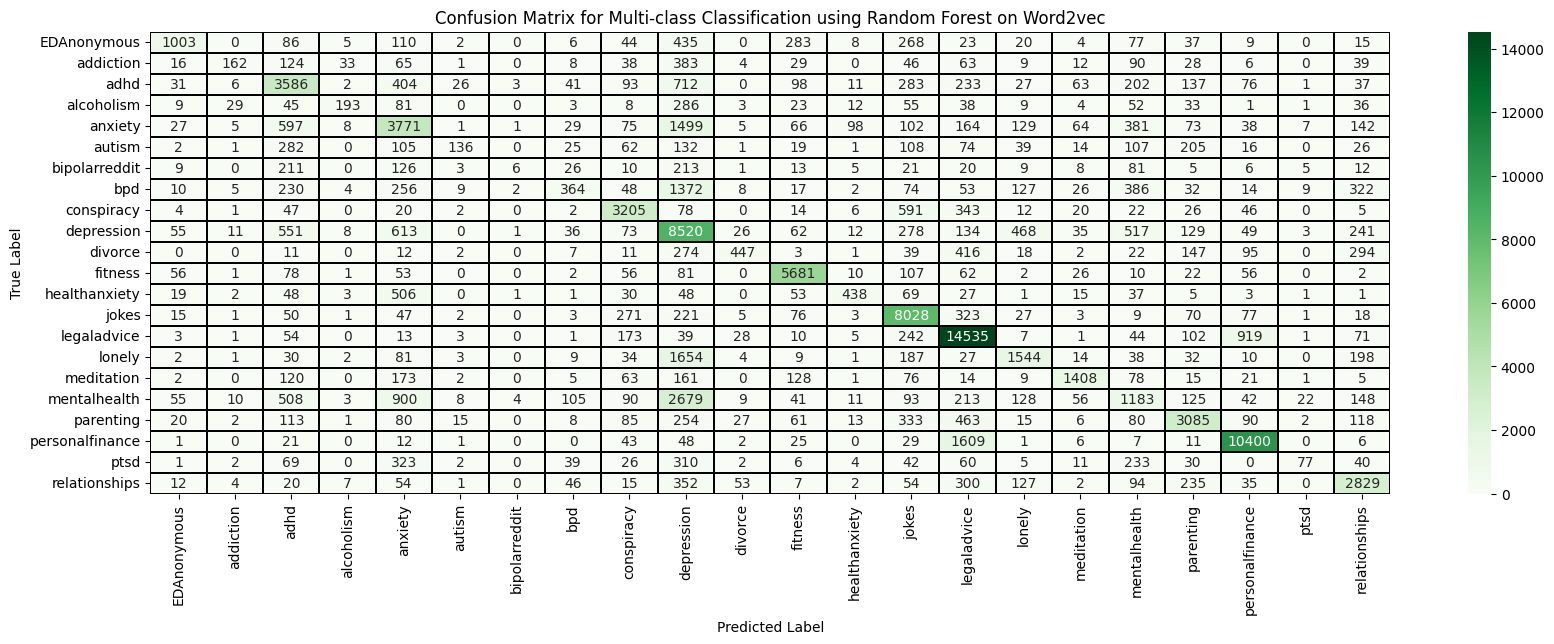

In [40]:
cm3_W2V = confusion_matrix(y3_W2V_test, y3_W2V_pred)

plt.figure(figsize = (20, 6))
sns.heatmap(cm3_W2V, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = le.classes_, yticklabels = le.classes_, linewidths = 0.3, linecolor ='black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification using Random Forest on Word2vec')
plt.show()

In [41]:
precision3_W2V = precision_score(y3_W2V_test, y3_W2V_pred, average = 'weighted')
recall3_W2V = recall_score(y3_W2V_test, y3_W2V_pred, average = 'weighted')

print("Accuracy3_W2V:", accuracy_score(y3_W2V_test, y3_W2V_pred))
print(f"Weighted Precision3_W2V: {precision3_W2V:.4f}")
print(f"Weighted Recall3_TFIDF: {recall3_W2V:.4f}")
print("Classification Report 3_W2V:")
print(classification_report(y3_W2V_test, y3_W2V_pred, target_names = le.classes_))

Accuracy3_W2V: 0.6430900677694382
Weighted Precision3_W2V: 0.6428
Weighted Recall3_TFIDF: 0.6431
Classification Report 3_W2V:
                 precision    recall  f1-score   support

    EDAnonymous       0.74      0.41      0.53      2435
      addiction       0.66      0.14      0.23      1156
           adhd       0.52      0.59      0.55      6072
     alcoholism       0.71      0.21      0.32       921
        anxiety       0.48      0.52      0.50      7282
         autism       0.62      0.10      0.17      1355
  bipolarreddit       0.33      0.01      0.01       790
            bpd       0.48      0.11      0.18      3370
     conspiracy       0.70      0.72      0.71      4444
     depression       0.43      0.72      0.54     11822
        divorce       0.72      0.25      0.37      1801
        fitness       0.84      0.90      0.87      6306
  healthanxiety       0.68      0.33      0.45      1308
          jokes       0.72      0.87      0.79      9251
    legaladvice   

## **Deep Learning Model (4): LSTM**

In [42]:
x4_TFIDF_train, x4_TFIDF_test, y4_TFIDF_train, y4_TFIDF_test = train_test_split(X_TFIDF, Y, test_size = 0.2, random_state = 42)
x4_W2V_train, x4_W2V_test, y4_W2V_train, y4_W2V_test = train_test_split(X_W2V, Y, test_size = 0.2, random_state = 42)

***Building the LSTM model on TF-IDF matrix:***

In [ ]:
# X_train_lstm1 = x4_TFIDF_train.reshape((x4_TFIDF_train.shape[0], 1, x4_TFIDF_train.shape[1]))
# X_test_lstm1 = x4_TFIDF_test.reshape((x4_TFIDF_test.shape[0], 1, x4_TFIDF_test.shape[1]))

In [ ]:
# # Building the LSTM model:

# lstm_model_TFIDF = Sequential([
#     LSTM(64, input_shape = (X_train_lstm1.shape[1], X_train_lstm1.shape[2]), activation = 'relu'),
#     Dropout(0.2),
#     Dense(32, activation = 'relu'),
#     Dropout(0.2),
#     Dense(len(le.classes_), activation = 'softmax')
# ])

In [43]:
# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
# lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2)
# lstm_model_TFIDF.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# lstm_model_TFIDF.fit(X_train_lstm1, y4_TFIDF_train, epochs = 40, batch_size = 256, validation_split = 0.1)

# y4_TFIDF_pred = np.argmax(lstm_model_TFIDF.predict(X_test_lstm1), axis = -1)

In [44]:
# cm4_TFIDF = confusion_matrix(y4_TFIDF_test, y4_TFIDF_pred)

# plt.figure(figsize = (20, 6))
# sns.heatmap(cm4_TFIDF, annot = True, fmt = 'd', cmap = 'Reds', xticklabels = le.classes_, yticklabels = le.classes_, linewidths = 0.3, linecolor = 'black')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Multi-class Classification for LSTM Model on TF-IDF')
# plt.show()

In [45]:
# accuracy4_TFIDF = accuracy_score(y4_TFIDF_test, y4_TFIDF_pred)
# precision4_TFIDF = precision_score(y4_TFIDF_test, y4_TFIDF_pred, average = 'weighted')
# recall4_TFIDF = recall_score(y4_TFIDF_test, y4_TFIDF_pred, average = 'weighted')

# print(f"Test Accuracy4_TFIDF: {accuracy4_TFIDF:.4f}")
# print(f"Weighted Precision4_TFIDF: {precision4_TFIDF:.4f}")
# print(f"Weighted Recall4_TFIDF: {recall4_TFIDF:.4f}")
# print("Classification Report 4_TFIDF:")
# print(classification_report(y4_TFIDF_test, y4_TFIDF_pred, target_names = le.classes_))

***Building the LSTM model on Word2vec embedding:***

In [46]:
X_train_lstm2 = x4_W2V_train.reshape((x4_W2V_train.shape[0], 1, x4_W2V_train.shape[1]))
X_test_lstm2 = x4_W2V_test.reshape((x4_W2V_test.shape[0], 1, x4_W2V_test.shape[1]))

In [47]:
lstm_model_W2V = Sequential([
    LSTM(64, input_shape = (X_train_lstm2.shape[1], X_train_lstm2.shape[2]), activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation = 'softmax')
])

In [48]:
lstm_model_W2V.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
lstm_model_W2V.fit(X_train_lstm2, y4_W2V_train, epochs = 40, batch_size = 256, validation_split = 0.1)

y4_W2V_pred = np.argmax(lstm_model_W2V.predict(X_test_lstm2), axis = -1)

Epoch 1/40
1544/1544 [==============================] - 9s 5ms/step - loss: 1.4295 - accuracy: 0.5688 - val_loss: 1.0842 - val_accuracy: 0.6649
Epoch 2/40
1544/1544 [==============================] - 7s 5ms/step - loss: 1.1696 - accuracy: 0.6437 - val_loss: 1.0179 - val_accuracy: 0.6847
Epoch 3/40
1544/1544 [==============================] - 7s 5ms/step - loss: 1.1210 - accuracy: 0.6579 - val_loss: 0.9895 - val_accuracy: 0.6920
Epoch 4/40
1544/1544 [==============================] - 7s 5ms/step - loss: 1.0949 - accuracy: 0.6657 - val_loss: 0.9725 - val_accuracy: 0.6964
Epoch 5/40
1544/1544 [==============================] - 7s 5ms/step - loss: 1.0766 - accuracy: 0.6707 - val_loss: 0.9608 - val_accuracy: 0.7001
Epoch 6/40
1544/1544 [==============================] - 7s 5ms/step - loss: 1.0635 - accuracy: 0.6742 - val_loss: 0.9519 - val_accuracy: 0.7035
Epoch 7/40
1544/1544 [==============================] - 7s 5ms/step - loss: 1.0532 - accuracy: 0.6779 - val_loss: 0.9446 - val_accuracy:

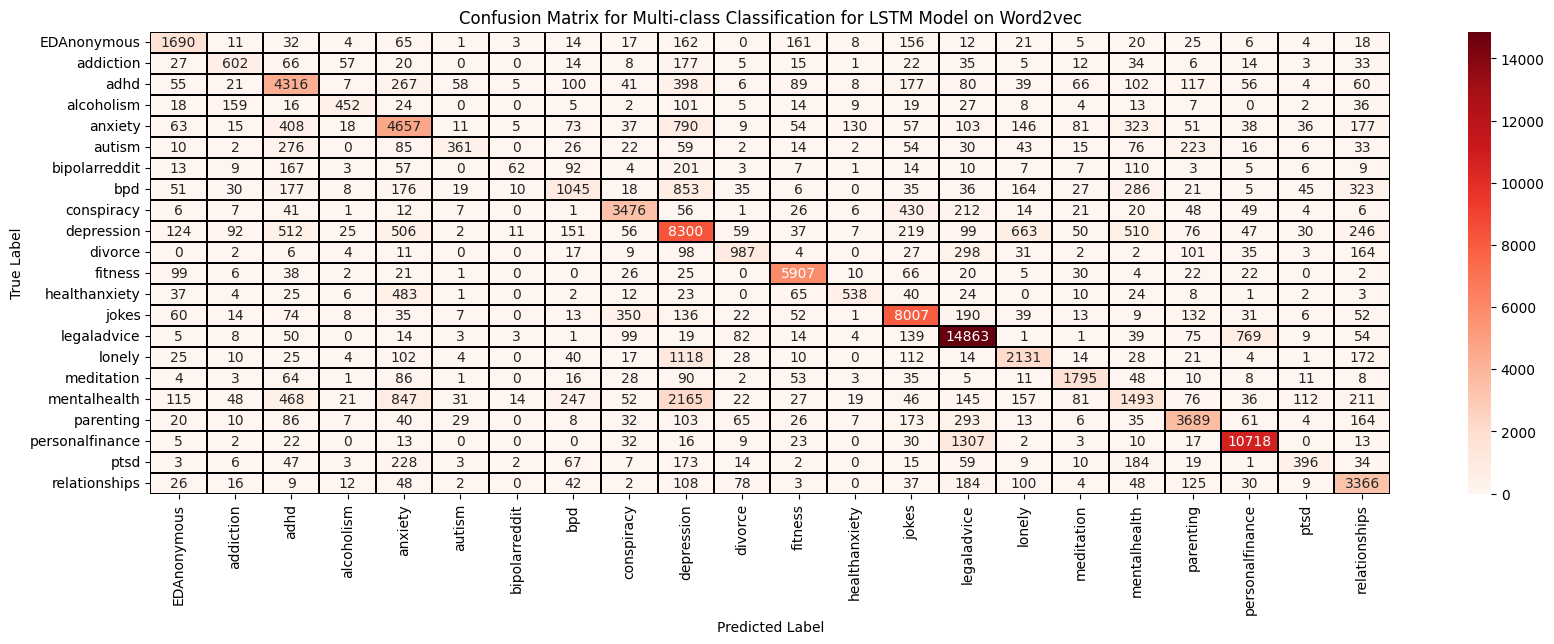

In [49]:
cm4_W2V = confusion_matrix(y4_W2V_test, y4_W2V_pred)

plt.figure(figsize = (20, 6))
sns.heatmap(cm4_W2V, annot = True, fmt = 'd', cmap = 'Reds', xticklabels = le.classes_, yticklabels = le.classes_, linewidths = 0.3, linecolor = 'black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Multi-class Classification for LSTM Model on Word2vec')
plt.show()

In [53]:
accuracy4_W2V = accuracy_score(y4_W2V_test, y4_W2V_pred)
precision4_W2V = precision_score(y4_W2V_test, y4_W2V_pred, average = 'weighted')
recall4_W2V = recall_score(y4_W2V_test, y4_W2V_pred, average = 'weighted')

print(f"Test Accuracy4_W2V: {accuracy4_W2V:.4f}")
print(f"Weighted Precision4_W2V: {precision4_W2V:.4f}")
print(f"Weighted Recall4_W2V: {recall4_W2V:.4f}")
print("Classification Report 4_W2V:")
print(classification_report(y4_W2V_test, y4_W2V_pred, target_names = le.classes_))

Test Accuracy4_W2V: 0.7182
Weighted Precision4_W2V: 0.7101
Weighted Recall4_W2V: 0.7182
Classification Report 4_W2V:
                 precision    recall  f1-score   support

    EDAnonymous       0.69      0.69      0.69      2435
      addiction       0.56      0.52      0.54      1156
           adhd       0.62      0.71      0.66      6072
     alcoholism       0.70      0.49      0.58       921
        anxiety       0.60      0.64      0.62      7282
         autism       0.67      0.27      0.38      1355
  bipolarreddit       0.54      0.08      0.14       790
            bpd       0.53      0.31      0.39      3370
     conspiracy       0.80      0.78      0.79      4444
     depression       0.55      0.70      0.61     11822
        divorce       0.69      0.55      0.61      1801
        fitness       0.89      0.94      0.91      6306
  healthanxiety       0.71      0.41      0.52      1308
          jokes       0.81      0.87      0.84      9251
    legaladvice       0.82 